### YOLO dataset creator. 

YOLO is a segmentation network. [There is a colab notebook for finetuning it on your custom dataset](https://colab.research.google.com/drive/1YnbqOinBZV-c9I7fk_UL6acgnnmkXDMM#scrollTo=VyD5KHSUr5ow). Therefore I will make a dataset using the emnist characters. I will place the characters so that they look like the dataset, and store the images and the bounding boxes. This will be then used for finetuning. 

One potential issue is that this network will not take into account the number,letter,number... pattern. However lets see how it does. 

The network will identify characters and their bounding boxes. We can hopefully then look at the CoM of the boxes to determine the ID.

In [183]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import TensorDataset, DataLoader
# from ML_helper import *
import h5py
from skimage.transform import rotate, resize, rescale
from PIL import Image
import ultralytics
ultralytics.checks()


by_merge_map = {0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9', 10:'A', 11:'B', 12:'C', 13:'D', 14:'E', 15:'F', 16:'G', 17:'H', 18:'I', 19:'J', 20:'K', 21:'L', 22:'M', 23:'N', 24:'O', 25:'P', 26:'Q', 27:'R', 28:'S', 29:'T', 30:'U', 31:'V', 32:'W', 33:'X', 34:'Y', 35:'Z', 36:'a', 37:'b', 38:'d', 39:'e', 40:'f', 41:'g', 42:'h', 43:'n', 44:'q', 45:'r', 46:'t'}
relevant_characters =  {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'A',10:'B',11:'C',12:'F',13:'G',14:'K',15:'N',16:'O',17:'P',18:'R',19:'S',20:'V',21:'W',22:'Y'}

def convert_labels_to_relevant(labels, original_label_dict, new_label_dict):
    new_labels = np.zeros_like(labels)
    
    for n,label in enumerate(labels):
        char = original_label_dict[label]
        new_labels[n] = list(new_label_dict.values()).index(char)
    return new_labels

def id_to_char(labels, keys_list):
    'convert the id into the corresponding character'
    labels = np.array(labels)
    return [keys_list[label] for label in labels]
   

Ultralytics YOLOv8.0.20  Python-3.10.12 torch-2.0.1 CPU
Setup complete  (16 CPUs, 23.7 GB RAM, -1091.6/75.0 GB disk)


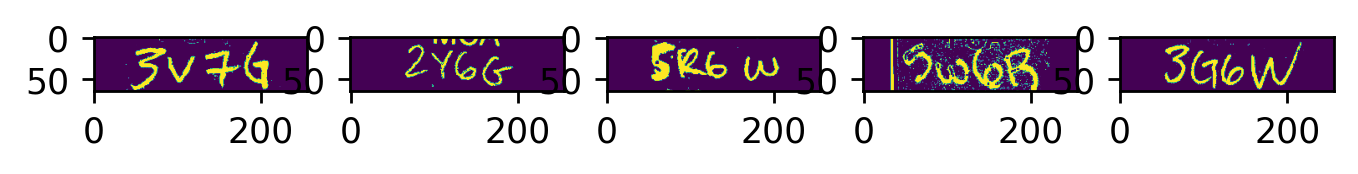

In [3]:
f = h5py.File('dataset.h5','r')
fig,ax = plt.subplots(1,5,dpi=250)
for i in range(5):
    ax[i].imshow(f['images'][i])

In [4]:
h5py

<module 'h5py' from 'c:\\Users\\howards\\Anaconda3\\envs\\torchenv\\lib\\site-packages\\h5py\\__init__.py'>

In [56]:
model = torch.load('../YOLOdata/best.pt')['model'].float()

In [153]:
a = f['images'][:10]

images_prefix = "../YOLOdata/test/"

store_filenames = []

for exno,img in enumerate(a):
    img = (((img - img.min()) / (img.max() - img.min())) * 255.9)

    img = Image.fromarray(np.uint8(img))
    img = img.convert("L")

    filename = images_prefix + f"im{exno}.jpg"
    img.save(filename)
    store_filenames.append(filename)

In [154]:
from ultralytics import YOLO
model = YOLO('../YOLOdata/best.pt')

In [155]:
image_path = '../YOLOdata/dataset/im0.jpg'

model.predict(image_path)

Ultralytics YOLOv8.0.20  Python-3.10.12 torch-2.0.1 CPU
Model summary (fused): 168 layers, 11134485 parameters, 0 gradients, 28.5 GFLOPs


[Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
 type: <class 'torch.Tensor'>
 shape: torch.Size([4, 6])
 dtype: torch.float32
  + tensor([[ 80.00000,  18.00000, 106.00000,  55.00000,   0.93289,  12.00000],
         [ 34.00000,  10.00000,  69.00000,  57.00000,   0.92748,   4.00000],
         [136.00000,   9.00000, 173.00000,  56.00000,   0.90431,  21.00000],
         [116.00000,  26.00000, 131.00000,  56.00000,   0.90097,   1.00000]])]

In [157]:
results = [model.predict(img)[0] for img in store_filenames]

In [158]:
results[0]

Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
type: <class 'torch.Tensor'>
shape: torch.Size([4, 6])
dtype: torch.float32
 + tensor([[ 89.00000,  24.00000, 121.00000,  54.00000,   0.88800,  20.00000],
        [ 42.00000,  13.00000,  87.00000,  60.00000,   0.88782,   3.00000],
        [179.00000,   7.00000, 210.00000,  58.00000,   0.86877,  13.00000],
        [133.00000,  14.00000, 176.00000,  61.00000,   0.75789,  12.00000]])

In [165]:
results[0].boxes.cls

tensor([20.,  3., 13., 12.])

In [190]:
data = results[0].boxes.data
orde = torch.argsort(data[:,0],dim=0)
data = data[orde]
classes = data[:,-1].to(torch.int).numpy()
boxes = data[:,:-2].numpy()
probs = data[:,-2].numpy()

Character:  3   Confidence:  0.8878225
Character:  V   Confidence:  0.888001
Character:  F   Confidence:  0.7578939
Character:  G   Confidence:  0.8687738


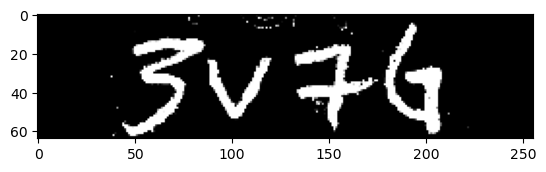

In [197]:
from matplotlib.patches import Rectangle


chars = id_to_char(classes,keys_list = relevant_characters)
plt.imshow(a[0], cmap='gray')

for i in range(len(chars)):
    print('Character: ',chars[i], '  Confidence: ', probs[i])
# ax = plt.gca()
# # Create a Rectangle patch
# rect = Rectangle((0,0),40,30,linewidth=1,edgecolor='r',facecolor='none')

# # Add the patch to the Axes
# ax.add_patch(rect)

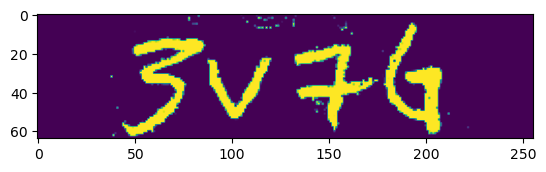